In [1]:
import sys

# Add root path
sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

from utils import MNIST, accuracy

In [3]:
dataset = MNIST(Path('../data/train'), transform=ToTensor())

In [4]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/train
    StandardTransform
Transform: ToTensor()

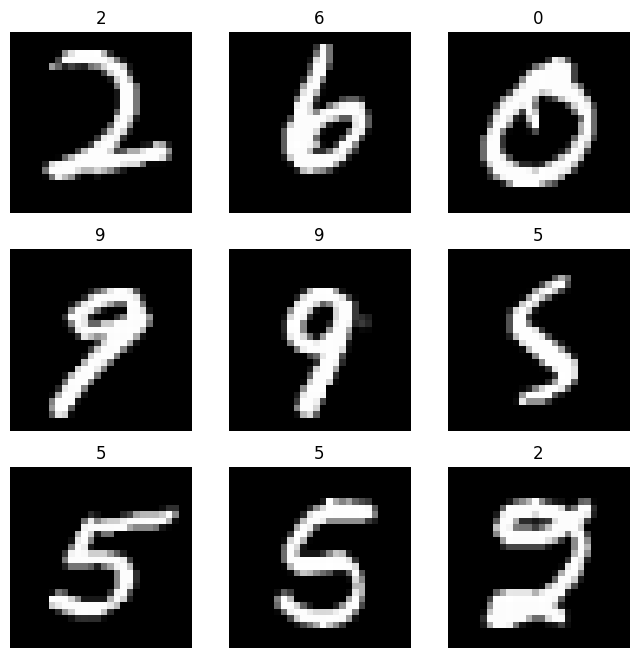

In [5]:
dataset.show_batch()

In [6]:
train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64)

In [8]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [9]:
# Get cpu, gpu or mps device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [10]:
from models.LeNet5.arch import LeNet5

In [11]:
model = LeNet5().to(device)

print(model)

LeNet5(
  (layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    len_dataset = len(dataloader.dataset)

    model.train()
    for batch, (X, y_true) in enumerate(dataloader):
        # Forward pass
        X, y_true = X.to(device), y_true.to(device)
        y_pred = model(X)

        # Compute prediction error
        loss = loss_fn(y_pred, y_true)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print stats
        if batch % 100 == 0:
            loss = loss.item()
            current_batch = (batch + 1) * len(X)
            acc = accuracy(y_true, y_pred)
            print(f"Loss: {loss:>3.3f} Accuracy: {acc:>4.3f}% Current Batch: [{current_batch:>5d}/{len_dataset:>5d}]")

In [14]:
def valid(dataloader, model, loss_fn):
    len_dataset = len(dataloader.dataset)
    num_batches = dataloader.batch_size
    test_loss = 0.0
    acc = 0.0

    model.eval()
    with torch.no_grad():
        for X, y_true in dataloader:
            # Forward pass
            X, y_true = X.to(device), y_true.to(device)
            y_pred = model(X)

            # Compute prediction error and accuracy
            test_loss += loss_fn(y_pred, y_true).item()
            acc += accuracy(y_true, y_pred)

    # Print stats
    test_loss /= num_batches
    acc /= len_dataset
    print(
        f"Valid Error: \n Accuracy: {(100*acc):>4.3f}%, Avg loss: {test_loss:>3.3f} \n")

In [15]:
epochs = 5
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    valid(valid_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.312 Accuracy: 5.000% Current Batch: [   64/42000]
Loss: 0.460 Accuracy: 58.000% Current Batch: [ 6464/42000]
Loss: 0.264 Accuracy: 60.000% Current Batch: [12864/42000]
Loss: 0.138 Accuracy: 61.000% Current Batch: [19264/42000]
Loss: 0.196 Accuracy: 62.000% Current Batch: [25664/42000]
Loss: 0.069 Accuracy: 63.000% Current Batch: [32064/42000]
Loss: 0.169 Accuracy: 60.000% Current Batch: [38464/42000]
Valid Error: 
 Accuracy: 96.717%, Avg loss: 0.451 

Epoch 2
-------------------------------
Loss: 0.159 Accuracy: 61.000% Current Batch: [   64/42000]
Loss: 0.215 Accuracy: 62.000% Current Batch: [ 6464/42000]
Loss: 0.052 Accuracy: 62.000% Current Batch: [12864/42000]
Loss: 0.098 Accuracy: 62.000% Current Batch: [19264/42000]
Loss: 0.079 Accuracy: 62.000% Current Batch: [25664/42000]
Loss: 0.019 Accuracy: 64.000% Current Batch: [32064/42000]
Loss: 0.024 Accuracy: 63.000% Current Batch: [38464/42000]
Valid Error: 
 Accuracy: 98.017%, Avg loss:

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [17]:
def test(dataloader, model, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    y_true = []
    y_pred = []
    len_dataset = len(dataloader.dataset)
    num_batches = dataloader.batch_size
    with torch.no_grad():
        for X, y in dataloader:
            # Forward pass
            X, y = X.to(device), y.to(device)
            preds = model(X)

            # Compute prediction error and accuracy
            loss += loss_fn(preds, y).item()
            acc += accuracy(y, preds)

            y_true.extend(y.tolist())
            y_pred.extend(preds.tolist())

    loss /= num_batches
    acc = 100.0 * (acc / len_dataset)
    target_names = [str(label) for label in range(10)]

    print(
        f'Test set: Average loss: {loss:>3.3f}, Accuracy: {acc:>3.3f}%')

    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred).argmax(axis=-1)
    
    return y_true, y_pred, target_names

In [18]:
y_true, y_pred, target_names = test(valid_dataloader, model, loss_fn)

Test set: Average loss: 0.224, Accuracy: 98.389%


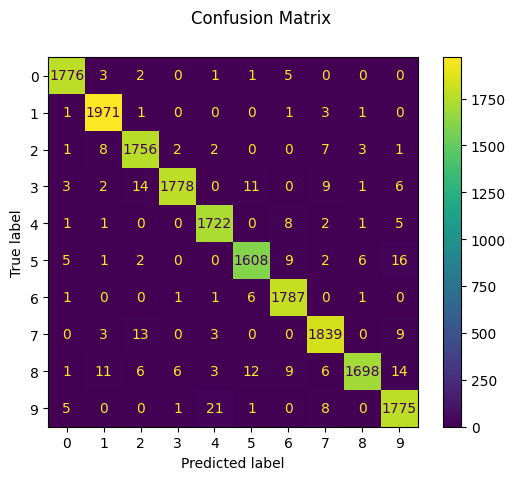

In [19]:
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1788
           1       0.99      1.00      0.99      1978
           2       0.98      0.99      0.98      1780
           3       0.99      0.97      0.98      1824
           4       0.98      0.99      0.99      1740
           5       0.98      0.98      0.98      1649
           6       0.98      0.99      0.99      1797
           7       0.98      0.99      0.98      1867
           8       0.99      0.96      0.98      1766
           9       0.97      0.98      0.98      1811

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



## Save model

In [21]:
models_path = Path('../models/')
LeNet5_model_path = models_path / "LeNet5/LeNet5.pth"

In [22]:
torch.save(model.state_dict(), LeNet5_model_path)
print(f"Saved PyTorch Model State to {LeNet5_model_path}")

Saved PyTorch Model State to ../models/LeNet5/LeNet5.pth
